# Do We Really Need Skip Connections?

## Introduction

In deep neural networks, skip connections (or residual connections) have become a cornerstone for improving performance and training efficiency. In this section, we explore the concept of skip connections, their advantages in forward and backpropagation, and present an alternative approach: the **Activation Switch (ActiSwitch) layer**.

## What Are Skip Connections?

Skip connections allow neural networks to bypass one or more layers, sending inputs directly to deeper layers. This bypass mechanism provides multiple benefits:

### Benefits in Forward Propagation

1. **Preserving Features**: Skip connections enable the network to retain critical information from earlier layers, which is especially important for tasks like object detection. Lower-level features such as edges and textures are crucial for accurate detection, and skip connections help ensure these features aren’t lost as the data flows through the network.

2. **Boosting Detection Accuracy**: Information from earlier layers often contains valuable details that may get diluted or distorted in deeper layers. By preserving this information, skip connections improve detection accuracy in complex tasks.

### Benefits in Backpropagation

1. **Tackling Vanishing Gradients**: As gradients propagate backward through many layers in deep networks, they can shrink (vanish), making it difficult to update weights effectively. Skip connections provide a direct route for gradients to flow, helping mitigate the vanishing gradient problem.

2. **Efficient Loss Signal Transmission**: By allowing the gradient to bypass layers, skip connections create a shortcut for the loss signal, making it easier to train very deep networks.

## Introducing the ActiSwitch Layer

While skip connections offer clear advantages, the **ActiSwitch layer** provides an alternative that dynamically adapts between linear and non-linear activations.

### What is ActiSwitch?

The ActiSwitch layer can smoothly transition between a linear and non-linear activation function during training. Initially acting as a linear identity layer, it gradually introduces non-linearity as needed, combining the advantages of both behaviors:

1. **Balancing Linearity and Non-Linearity**: The ActiSwitch layer enables the network to maintain linearity where it benefits performance and introduce non-linearity where needed to capture more complex patterns.

2. **Dynamic Adaptation**: By adjusting the balance between linear and non-linear transformations, ActiSwitch adapts based on the network’s needs, leading to better performance than using a static activation function.

### Comparison with Skip Connections

- **Performance**: In some cases, ActiSwitch can outperform skip connections, particularly when traditional activation functions like sigmoid or tanh are used. However, when using more robust activations like ReLU, ActiSwitch may take longer to reach comparable accuracy or require additional epochs. The layer's ability to blend linear and non-linear behaviors ensures it captures relevant patterns while preventing vanishing gradients.

- **Gradient Flow**: ActiSwitch provides an effective gradient path similar to skip connections but does so without directly forcing previous layer outputs into deeper layers. The learnable parameter in ActiSwitch ensures a smooth gradient flow through both linear and non-linear paths.

- **Selective Feature Usage**: Unlike skip connections, which always include features from previous layers, the ActiSwitch layer allows the training algorithm to choose which features are useful. This can result in more adaptive and targeted feature usage, improving overall performance.

- **Efficiency**: One of ActiSwitch’s advantages is that it does not require reshaping outputs or adding extra layers like skip connections do. This reduces the overall parameter size and computational overhead, making it easier to design and train the network.

- **Direct Connectivity**: With ActiSwitch, each layer is directly connected to all subsequent layers via a linear path, allowing uninterrupted information flow. This dense connectivity can provide benefits similar to skip connections without the complexity of adding residual layers.

## Comparative Performance

In practice, architectures that suffer from vanishing gradients—such as those with sigmoid activation functions—can see significant improvement using ActiSwitch over skip connections. However, for networks using ReLU or other piecewise linear functions, the performance of ActiSwitch may require additional training time to match the accuracy of networks with skip connections.

## Conclusion

Both skip connections and ActiSwitch layers play critical roles in neural network performance. Skip connections excel in preventing vanishing gradients and preserving features, while ActiSwitch offers a more flexible and adaptive solution by dynamically blending linear and non-linear activations. Though ActiSwitch can outperform skip connections in some cases, particularly when faced with activation functions prone to vanishing gradients, skip connections may still hold the advantage in scenarios where ReLU or similar functions are used.

### Import required libs and set Seeds 

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary

from atgen.layers.activations import ActiSwitch

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)

### Define the CNN model with separate activation functions for each layer

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, activations):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activations = activations

    def forward(self, x: torch.Tensor):
        x = self.pool(self.activations['conv1'](self.conv1(x)))
        x = self.pool(self.activations['conv2'](self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = self.activations['fc1'](self.fc1(x))
        x = self.activations['fc2'](self.fc2(x))
        x = self.fc3(x)
        return x

### Hyperparameters, Data loading and preprocessing, Define activation functions for each model and Training and evaluation

In [27]:
batch_size = 32
learning_rate = 0.001
num_epochs = 5


transform = transforms.Compose([
    transforms.ToTensor(),          
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

activation_configs = {
    'ReLU': {'conv1': nn.ReLU(), 'conv2': nn.ReLU(), 'fc1': nn.ReLU(), 'fc2': nn.ReLU()},
    'Tanh': {'conv1': nn.Tanh(), 'conv2': nn.Tanh(), 'fc1': nn.Tanh(), 'fc2': nn.Tanh()},
    'Sigmoid': {'conv1': nn.Sigmoid(), 'conv2': nn.Sigmoid(), 'fc1': nn.Sigmoid(), 'fc2': nn.Sigmoid()},
    'ActiSwitch(ReLU)': {'conv1': ActiSwitch(nn.ReLU), 'conv2': ActiSwitch(nn.ReLU), 'fc1': ActiSwitch(nn.ReLU), 'fc2': ActiSwitch(nn.ReLU)},
    'ActiSwitch(Tanh)': {'conv1': ActiSwitch(nn.Tanh), 'conv2': ActiSwitch(nn.Tanh), 'fc1': ActiSwitch(nn.Tanh), 'fc2': ActiSwitch(nn.Tanh)},
    'ActiSwitch(Sigmoid)': {'conv1': ActiSwitch(nn.Sigmoid), 'conv2': ActiSwitch(nn.Sigmoid), 'fc1': ActiSwitch(nn.Sigmoid), 'fc2': ActiSwitch(nn.Sigmoid)}
}

results = {
    'losses': {key: [] for key in activation_configs.keys()},
    'accuracies': {key: 0 for key in activation_configs.keys()}
}

### Training Phase for all models

In [28]:
for name, activations in activation_configs.items():
    print(f"\nTraining model with {name} activations...")
    
    # Initialize model, loss function, and optimizer
    model = SimpleCNN(activations)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Print model summary
    summary(model, input_size=(1, 28, 28))

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'{name} - Epoch {epoch+1}/{num_epochs}', unit='batch')):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()               
            outputs = model(data)               
            loss = criterion(outputs, target)   
            loss.backward()                     
            optimizer.step()                    

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        results['losses'][name].append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc=f'{name} - Evaluating', unit='batch'):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    results['accuracies'][name] = accuracy
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


Training model with ReLU activations...
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            200,832
├─Linear: 1-5                            8,256
├─Linear: 1-6                            650
Total params: 219,306
Trainable params: 219,306
Non-trainable params: 0


ReLU - Epoch 1/5: 100%|██████████| 1875/1875 [00:22<00:00, 82.34batch/s]


Epoch [1/5], Average Loss: 0.1417


ReLU - Epoch 2/5: 100%|██████████| 1875/1875 [00:24<00:00, 77.94batch/s]


Epoch [2/5], Average Loss: 0.0476


ReLU - Epoch 3/5: 100%|██████████| 1875/1875 [00:24<00:00, 78.01batch/s]


Epoch [3/5], Average Loss: 0.0334


ReLU - Epoch 4/5: 100%|██████████| 1875/1875 [00:21<00:00, 89.07batch/s]


Epoch [4/5], Average Loss: 0.0245


ReLU - Epoch 5/5: 100%|██████████| 1875/1875 [00:21<00:00, 88.87batch/s]


Epoch [5/5], Average Loss: 0.0195


ReLU - Evaluating: 100%|██████████| 313/313 [00:01<00:00, 167.34batch/s]


Accuracy of the model on the test set: 98.85%

Training model with Tanh activations...
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            200,832
├─Linear: 1-5                            8,256
├─Linear: 1-6                            650
Total params: 219,306
Trainable params: 219,306
Non-trainable params: 0


Tanh - Epoch 1/5: 100%|██████████| 1875/1875 [00:21<00:00, 86.79batch/s]


Epoch [1/5], Average Loss: 0.1437


Tanh - Epoch 2/5: 100%|██████████| 1875/1875 [00:21<00:00, 89.09batch/s]


Epoch [2/5], Average Loss: 0.0458


Tanh - Epoch 3/5: 100%|██████████| 1875/1875 [00:21<00:00, 85.55batch/s]


Epoch [3/5], Average Loss: 0.0332


Tanh - Epoch 4/5: 100%|██████████| 1875/1875 [00:20<00:00, 90.87batch/s]


Epoch [4/5], Average Loss: 0.0272


Tanh - Epoch 5/5: 100%|██████████| 1875/1875 [00:20<00:00, 91.30batch/s]


Epoch [5/5], Average Loss: 0.0205


Tanh - Evaluating: 100%|██████████| 313/313 [00:01<00:00, 169.23batch/s]


Accuracy of the model on the test set: 98.67%

Training model with Sigmoid activations...
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            200,832
├─Linear: 1-5                            8,256
├─Linear: 1-6                            650
Total params: 219,306
Trainable params: 219,306
Non-trainable params: 0


Sigmoid - Epoch 1/5: 100%|██████████| 1875/1875 [00:23<00:00, 79.38batch/s]


Epoch [1/5], Average Loss: 0.5237


Sigmoid - Epoch 2/5: 100%|██████████| 1875/1875 [00:21<00:00, 85.52batch/s]


Epoch [2/5], Average Loss: 0.0923


Sigmoid - Epoch 3/5: 100%|██████████| 1875/1875 [00:22<00:00, 84.66batch/s]


Epoch [3/5], Average Loss: 0.0615


Sigmoid - Epoch 4/5: 100%|██████████| 1875/1875 [00:24<00:00, 78.02batch/s]


Epoch [4/5], Average Loss: 0.0466


Sigmoid - Epoch 5/5: 100%|██████████| 1875/1875 [00:21<00:00, 86.28batch/s]


Epoch [5/5], Average Loss: 0.0397


Sigmoid - Evaluating: 100%|██████████| 313/313 [00:01<00:00, 175.45batch/s]


Accuracy of the model on the test set: 98.54%

Training model with ActiSwitch(ReLU) activations...
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            200,832
├─Linear: 1-5                            8,256
├─Linear: 1-6                            650
Total params: 219,306
Trainable params: 219,306
Non-trainable params: 0


ActiSwitch(ReLU) - Epoch 1/5: 100%|██████████| 1875/1875 [00:43<00:00, 42.82batch/s]


Epoch [1/5], Average Loss: 0.1412


ActiSwitch(ReLU) - Epoch 2/5: 100%|██████████| 1875/1875 [00:40<00:00, 45.89batch/s]


Epoch [2/5], Average Loss: 0.0481


ActiSwitch(ReLU) - Epoch 3/5: 100%|██████████| 1875/1875 [00:40<00:00, 46.48batch/s]


Epoch [3/5], Average Loss: 0.0346


ActiSwitch(ReLU) - Epoch 4/5: 100%|██████████| 1875/1875 [00:40<00:00, 46.26batch/s]


Epoch [4/5], Average Loss: 0.0260


ActiSwitch(ReLU) - Epoch 5/5: 100%|██████████| 1875/1875 [00:40<00:00, 46.21batch/s]


Epoch [5/5], Average Loss: 0.0213


ActiSwitch(ReLU) - Evaluating: 100%|██████████| 313/313 [00:02<00:00, 150.69batch/s]


Accuracy of the model on the test set: 99.05%

Training model with ActiSwitch(Tanh) activations...
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            200,832
├─Linear: 1-5                            8,256
├─Linear: 1-6                            650
Total params: 219,306
Trainable params: 219,306
Non-trainable params: 0


ActiSwitch(Tanh) - Epoch 1/5: 100%|██████████| 1875/1875 [00:41<00:00, 45.43batch/s]


Epoch [1/5], Average Loss: 0.1425


ActiSwitch(Tanh) - Epoch 2/5: 100%|██████████| 1875/1875 [00:41<00:00, 45.64batch/s]


Epoch [2/5], Average Loss: 0.0488


ActiSwitch(Tanh) - Epoch 3/5: 100%|██████████| 1875/1875 [00:43<00:00, 42.87batch/s]


Epoch [3/5], Average Loss: 0.0367


ActiSwitch(Tanh) - Epoch 4/5: 100%|██████████| 1875/1875 [00:41<00:00, 45.43batch/s]


Epoch [4/5], Average Loss: 0.0284


ActiSwitch(Tanh) - Epoch 5/5: 100%|██████████| 1875/1875 [00:41<00:00, 45.56batch/s]


Epoch [5/5], Average Loss: 0.0245


ActiSwitch(Tanh) - Evaluating: 100%|██████████| 313/313 [00:02<00:00, 147.78batch/s]


Accuracy of the model on the test set: 98.80%

Training model with ActiSwitch(Sigmoid) activations...
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            9,248
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            200,832
├─Linear: 1-5                            8,256
├─Linear: 1-6                            650
Total params: 219,306
Trainable params: 219,306
Non-trainable params: 0


ActiSwitch(Sigmoid) - Epoch 1/5: 100%|██████████| 1875/1875 [00:40<00:00, 45.80batch/s]


Epoch [1/5], Average Loss: 0.6363


ActiSwitch(Sigmoid) - Epoch 2/5: 100%|██████████| 1875/1875 [00:41<00:00, 45.58batch/s]


Epoch [2/5], Average Loss: 0.1523


ActiSwitch(Sigmoid) - Epoch 3/5: 100%|██████████| 1875/1875 [00:41<00:00, 45.55batch/s]


Epoch [3/5], Average Loss: 0.0988


ActiSwitch(Sigmoid) - Epoch 4/5: 100%|██████████| 1875/1875 [00:40<00:00, 45.78batch/s]


Epoch [4/5], Average Loss: 0.0727


ActiSwitch(Sigmoid) - Epoch 5/5: 100%|██████████| 1875/1875 [00:40<00:00, 45.80batch/s]


Epoch [5/5], Average Loss: 0.0571


ActiSwitch(Sigmoid) - Evaluating: 100%|██████████| 313/313 [00:02<00:00, 144.82batch/s]

Accuracy of the model on the test set: 97.60%


### Results and Plotting

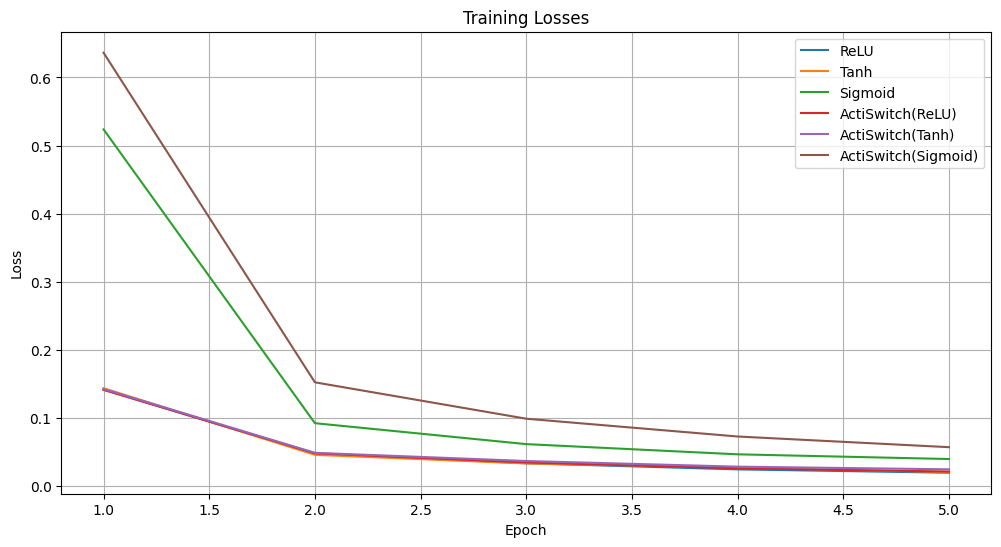

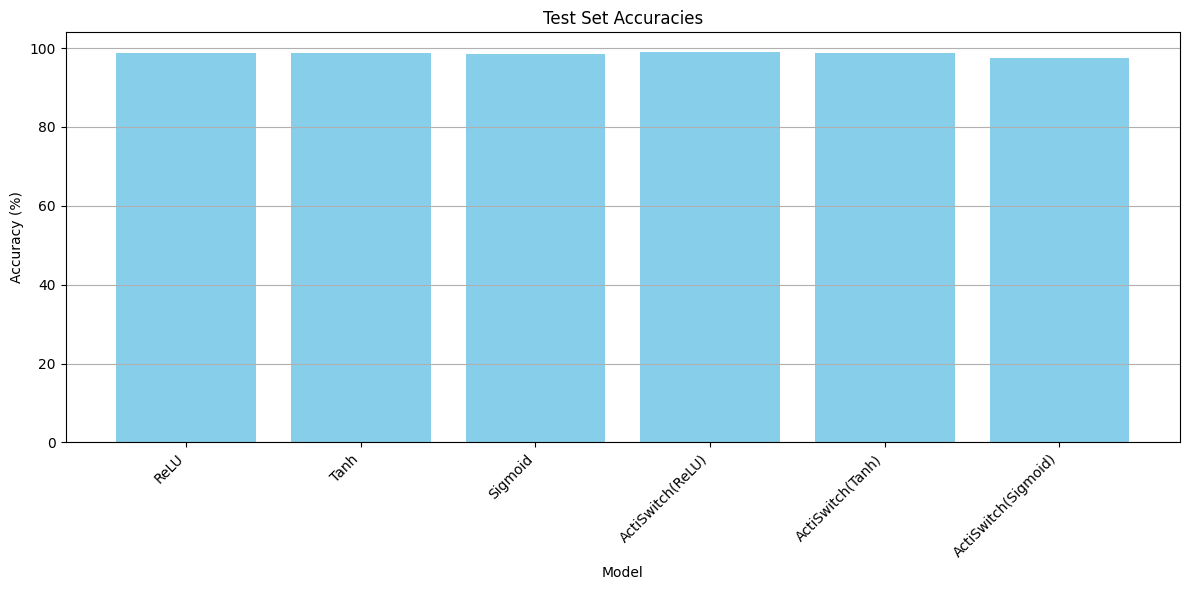

In [29]:
# Plot training losses
plt.figure(figsize=(12, 6))
for name, losses in results['losses'].items():
    plt.plot(range(1, num_epochs + 1), losses, label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
# plt.savefig('training_losses.png')
plt.show()

# Plot accuracies
plt.figure(figsize=(12, 6))
names = list(results['accuracies'].keys())
accuracies = list(results['accuracies'].values())
plt.bar(names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Test Set Accuracies')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
# plt.savefig('model_accuracies.png')
plt.show()